In [1]:
import pandas as pd  
import numpy as np  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import boxcox, shapiro, levene 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('D:/TEL-U/SEMESTER 7/TA/TAFORECAST/lagged_data.csv')
df

,Date,Close(t-10),Open(t-10),High(t-10),Low(t-10),Sentiment_Score(t-10),Adj Close(t-10),Close(t-9),Open(t-9),High(t-9),...,High(t-1),Low(t-1),Sentiment_Score(t-1),Adj Close(t-1),Close(t),Open(t),High(t),Low(t),Sentiment_Score(t),Adj Close(t)
0,2020-01-11,7200.174316,7194.892090,7254.330566,7174.944336,0.30,7200.174316,6985.470215,7202.551270,7212.155273,...,8166.554199,7726.774902,0.29,8166.554199,8037.537598,8162.190918,8218.359375,8029.642090,0.30,8037.537598
1,2020-01-12,6985.470215,7202.551270,7212.155273,6935.270020,-0.00,6985.470215,7344.884277,6984.428711,7413.715332,...,8218.359375,8029.642090,0.30,8037.537598,8192.494141,8033.261719,8200.063477,8009.059082,0.31,8192.494141
2,2020-01-13,7344.884277,6984.428711,7413.715332,6914.996094,0.22,7344.884277,7410.656738,7345.375488,7427.385742,...,8200.063477,8009.059082,0.31,8192.494141,8144.194336,8189.771973,8197.788086,8079.700684,0.13,8144.194336
3,2020-01-14,7410.656738,7345.375488,7427.385742,7309.514160,0.07,7410.656738,7411.317383,7410.451660,7544.497070,...,8197.788086,8079.700684,0.13,8144.194336,8827.764648,8140.933105,8879.511719,8140.933105,0.32,8827.764648
4,2020-01-15,7411.317383,7410.451660,7544.497070,7400.535645,0.21,7411.317383,7769.219238,7410.452148,7781.867188,...,8879.511719,8140.933105,0.32,8827.764648,8807.010742,8825.343750,8890.117188,8657.187500,0.02,8807.010742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,2024-11-14,67811.507812,68742.132812,69433.179688,66803.648438,0.30,67811.507812,69359.562500,67811.171875,70522.789062,...,93434.351562,86256.929688,0.28,90584.164062,87250.429688,90574.882812,91765.218750,86682.812500,0.30,87250.429688
1770,2024-11-15,69359.562500,67811.171875,70522.789062,67458.867188,0.42,69359.562500,75639.078125,69358.500000,76460.156250,...,91765.218750,86682.812500,0.30,87250.429688,91066.007812,87284.179688,91868.742188,87124.898438,0.35,91066.007812
1771,2024-11-16,75639.078125,69358.500000,76460.156250,69322.031250,0.16,75639.078125,75904.859375,75637.085938,76943.117188,...,91868.742188,87124.898438,0.35,91066.007812,90558.476562,91064.367188,91763.945312,90094.226562,0.13,90558.476562
1772,2024-11-17,75904.859375,75637.085938,76943.117188,74480.421875,0.09,75904.859375,76545.476562,75902.835938,77252.750000,...,91763.945312,90094.226562,0.13,90558.476562,89845.851562,90558.460938,91433.039062,88741.664062,0.15,89845.851562


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
# Differencing for stationarity  
df['Adj Close_diff'] = df['Adj Close(t)'].diff()  
df.dropna(inplace=True)  

In [5]:
df['Adj Close_boxcox'], lambda_bc = boxcox(df['Adj Close_diff'] + abs(df['Adj Close_diff'].min()) + 1)  

In [6]:
# Levene's test for variance homogeneity  
stat, p_value = levene(df['Adj Close_boxcox'], df['Sentiment_Score(t)'])  
print(f"Levene's test statistic: {stat}, p-value: {p_value}")  

Levene's test statistic: 1112.0919991757323, p-value: 2.5490692694222047e-212


In [7]:
# Feature Engineering for Scenario 2 (Sentiment Scores as features)  
n = 5  # Define the number of time steps (you can tune this value)  

for i in range(1, n + 1):  
    df[f"Sentiment_Score_t-{i}"] = df["Sentiment_Score(t)"].shift(i)  

# Drop rows with NaN values after shifting  
df.dropna(inplace=True)

In [8]:
y = df["Adj Close(t)"]

# Define features (Sentiment_Score from t-1 to t-n)  
X = df[[f"Sentiment_Score_t-{i}" for i in range(1, n + 1)]]

In [9]:
# Build ARIMAX model  
order = (9, 1, 9)  

# Fit the SARIMAX model with external regressors (Sentiment Scores)  
model = SARIMAX(y, exog=X, order=order)  
results = model.fit()  

# Print model summary  
print(results.summary()) 

                               SARIMAX Results                                
Dep. Variable:           Adj Close(t)   No. Observations:                 1768
Model:               SARIMAX(9, 1, 9)   Log Likelihood              -15143.080
Date:                Sun, 05 Jan 2025   AIC                          30334.160
Time:                        11:29:53   BIC                          30465.609
Sample:                    01-17-2020   HQIC                         30382.728
                         - 11-18-2024                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Sentiment_Score_t-1    66.2253    208.503      0.318      0.751    -342.433     474.883
Sentiment_Score_t-2  -107.7218    245.991     -0.438      0.661    -589.855     374.411
Sentiment_Score_

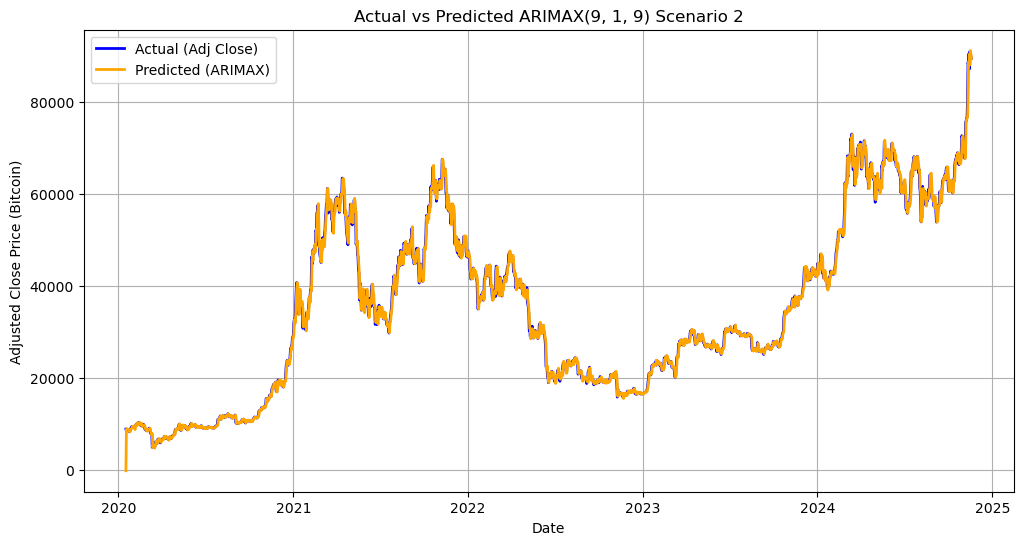

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Mengambil data 'Adj Close' dan fitur eksternal 'Sentiment_Score_t-1' hingga 'Sentiment_Score_t-n'
y = df["Adj Close(t)"]
n = 5  # Jumlah variabel lag Sentiment_Score
X = df[[f"Sentiment_Score_t-{i}" for i in range(1, n + 1)]]  # Fitur eksternal (Sentiment Score)

# Membuat dan menyesuaikan model ARIMAX
model = SARIMAX(y, exog=X, order=(9, 1, 9))  # Gantilah dengan parameter yang sesuai
results = model.fit()

# Hasil prediksi (fitted values)
fitted_values = results.fittedvalues

# Membuat plot perbandingan
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Actual (Adj Close)', color='blue', linewidth=2)
plt.plot(fitted_values.index, fitted_values, label='Predicted (ARIMAX)', color='orange', linewidth=2)

# Menambahkan judul dan label
plt.title('Actual vs Predicted ARIMAX(9, 1, 9) Scenario 2')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (Bitcoin)')
plt.legend()
plt.grid(True)
plt.show()

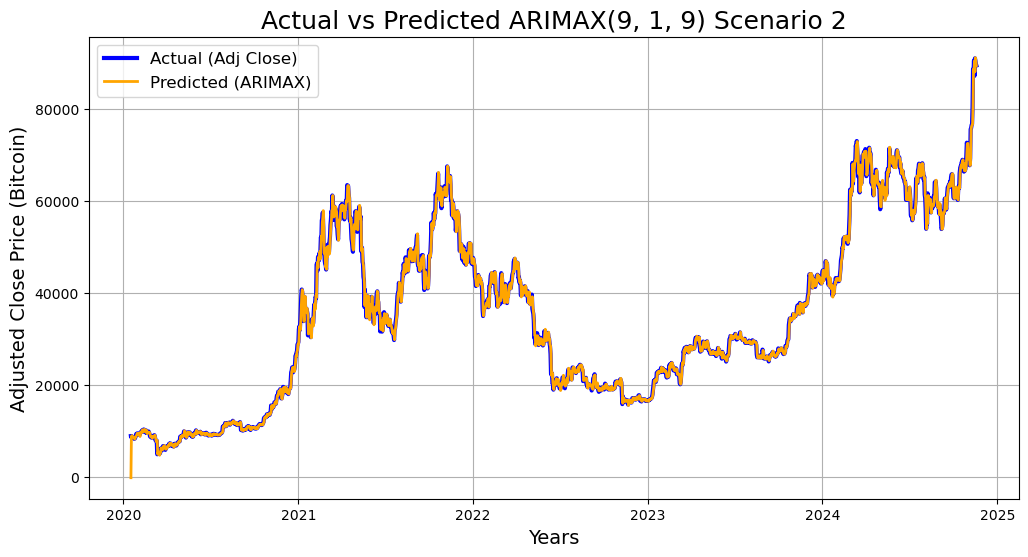

In [22]:
import matplotlib.pyplot as plt  
from statsmodels.tsa.statespace.sarimax import SARIMAX  

# Mengambil data 'Adj Close' dan fitur eksternal 'Sentiment_Score_t-1' hingga 'Sentiment_Score_t-n'  
y = df["Adj Close(t)"]  
n = 5  # Jumlah variabel lag Sentiment_Score  
X = df[[f"Sentiment_Score_t-{i}" for i in range(1, n + 1)]]  # Fitur eksternal (Sentiment Score)  

# Membuat dan menyesuaikan model ARIMAX  
model = SARIMAX(y, exog=X, order=(9, 1, 9))  # Gantilah dengan parameter yang sesuai  
results = model.fit()  

# Hasil prediksi (fitted values)  
fitted_values = results.fittedvalues  

# Membuat plot perbandingan  
plt.figure(figsize=(12, 6))  
plt.plot(y.index, y, label='Actual (Adj Close)', color='blue', linewidth=3)  # Meningkatkan linewidth  
plt.plot(fitted_values.index, fitted_values, label='Predicted (ARIMAX)', color='orange', linewidth=2)  

# Menambahkan judul dan label dengan ukuran font yang disesuaikan  
plt.title('Actual vs Predicted ARIMAX(9, 1, 9) Scenario 2', fontsize=18)  # Ukuran font judul  
plt.xlabel('Years', fontsize=14)  # Ukuran font label sumbu X  
plt.ylabel('Adjusted Close Price (Bitcoin)', fontsize=14)  # Ukuran font label sumbu Y  
plt.legend(fontsize=12)  # Ukuran font legenda  
plt.grid(True)  
plt.show()

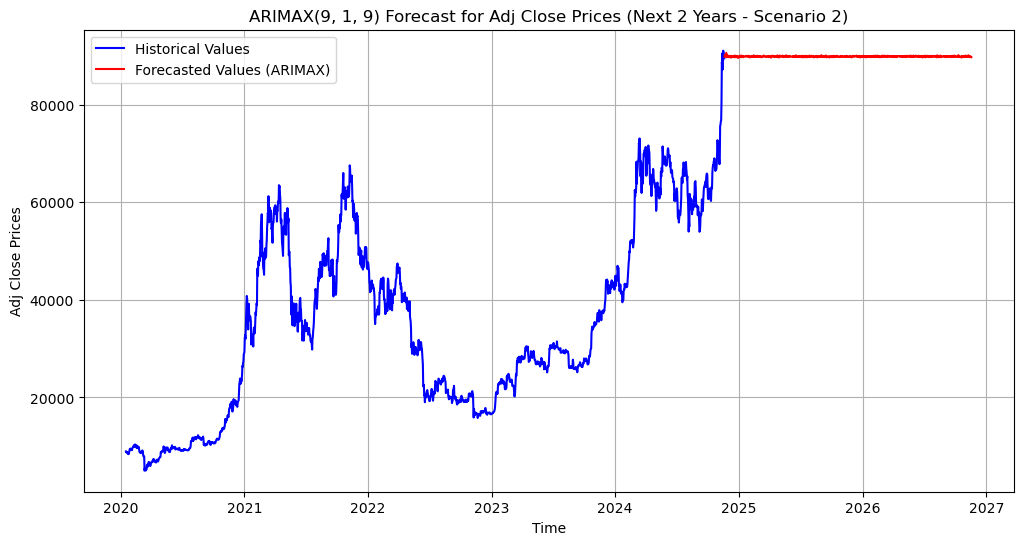

In [ ]:
# Tentukan parameter model  
best_order = (9, 1, 9)

# Target variable  
Y = df["Adj Close(t)"]

# Define features (Sentiment_Score from t-1 to t-n)  
n = 5  # Misalkan n didefinisikan sesuai kebutuhan  
X1 = df[[f"Sentiment_Score_t-{i}" for i in range(1, n + 1)]]

# Fit model ARIMAX  
model_scenario_2 = SARIMAX(Y, exog=X1, order=best_order)
results_scenario_2 = model_scenario_2.fit()

# Forecasting untuk n langkah ke depan (2 tahun)
n_steps = 365 * 2  # 730 langkah (2 tahun data)

# Prepare future exogenous variables (Sentiment_Score(t) untuk langkah ke depan)
future_sentiment_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='D')
future_sentiment = pd.DataFrame(index=future_sentiment_index, columns=X1.columns)

# Placeholder untuk future sentiment scores — ganti dengan prediksi atau estimasi yang realistis
# Di sini diisi dengan nilai acak; ini harus diganti dengan prediksi nyata
for i in range(1, n + 1):
    future_sentiment[f"Sentiment_Score_t-{i}"] = np.random.rand(n_steps)  # Nilai acak untuk demo

# Lakukan peramalan  
forecast = results_scenario_2.get_forecast(steps=n_steps, exog=future_sentiment)

# Ambil nilai yang diprediksi  
forecast_values = forecast.predicted_mean

# Plotting hasil peramalan  
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='Historical Values', color='blue')
plt.plot(future_sentiment.index, forecast_values, label='Forecasted Values (ARIMAX)', color='red')
plt.title('ARIMAX(9, 1, 9) Forecast for Adj Close Prices (Next 2 Years - Scenario 2)')
plt.xlabel('Time')
plt.ylabel('Adj Close Prices')
plt.legend()
plt.grid()
plt.show()

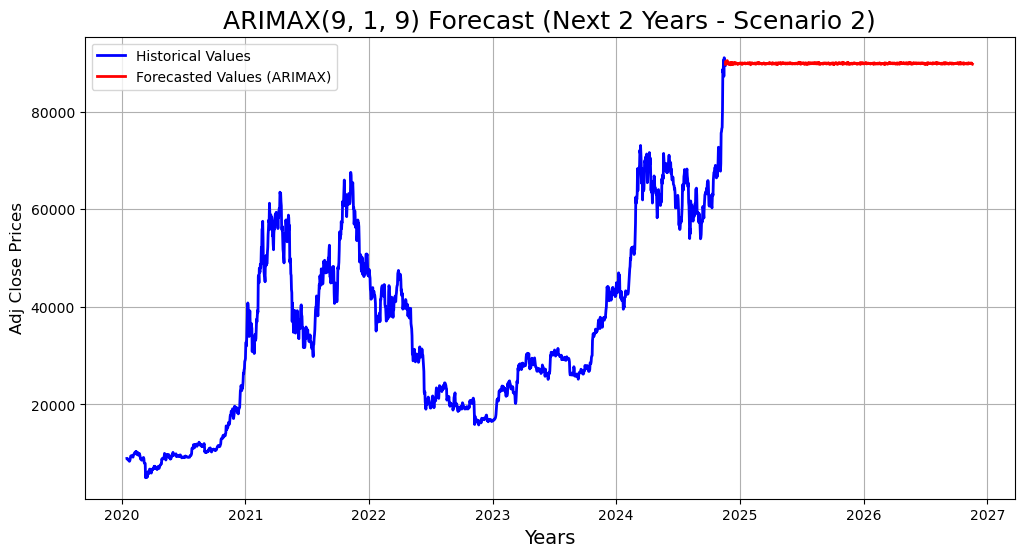

In [28]:
# Tentukan parameter model  
best_order = (9, 1, 9)

# Target variable  
Y = df["Adj Close(t)"]

# Define features (Sentiment_Score from t-1 to t-n)  
n = 5  # Misalkan n didefinisikan sesuai kebutuhan  
X1 = df[[f"Sentiment_Score_t-{i}" for i in range(1, n + 1)]]

# Fit model ARIMAX  
model_scenario_2 = SARIMAX(Y, exog=X1, order=best_order)
results_scenario_2 = model_scenario_2.fit()

# Forecasting untuk n langkah ke depan (2 tahun)
n_steps = 365 * 2  # 730 langkah (2 tahun data)

# Prepare future exogenous variables (Sentiment_Score(t) untuk langkah ke depan)
future_sentiment_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='D')
future_sentiment = pd.DataFrame(index=future_sentiment_index, columns=X1.columns)

# Placeholder untuk future sentiment scores — ganti dengan prediksi atau estimasi yang realistis
# Di sini diisi dengan nilai acak; ini harus diganti dengan prediksi nyata
for i in range(1, n + 1):
    future_sentiment[f"Sentiment_Score_t-{i}"] = np.random.rand(n_steps)  # Nilai acak untuk demo

# Lakukan peramalan  
forecast = results_scenario_2.get_forecast(steps=n_steps, exog=future_sentiment)

# Ambil nilai yang diprediksi  
forecast_values = forecast.predicted_mean

# Plotting hasil peramalan  
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='Historical Values', color='blue', linewidth=2)
plt.plot(future_sentiment.index, forecast_values, label='Forecasted Values (ARIMAX)', color='red', linewidth=2)
plt.title('ARIMAX(9, 1, 9) Forecast (Next 2 Years - Scenario 2)', fontsize=18)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Adj Close Prices', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error  

actual_future_values = pd.Series(data=np.random.rand(n_steps) * (Y.max() - Y.min()) + Y.min(),  
                                  index=future_sentiment_index)  

# Calculate evaluation metrics  
mse = mean_squared_error(actual_future_values, forecast_values)  
rmse = np.sqrt(mse)  
mae = mean_absolute_error(actual_future_values, forecast_values)  

# Output metrics (ensure they are floats)  
print(f'Mean Squared Error (MSE): {float(mse):.2f}')  
print(f'Root Mean Squared Error (RMSE): {float(rmse):.2f}')  
print(f'Mean Absolute Error (MAE): {float(mae):.2f}')  

Mean Squared Error (MSE): 2284831765.03
Root Mean Squared Error (RMSE): 47799.91
Mean Absolute Error (MAE): 40936.45
